In [ ]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-plot

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc
!pip install -q vit-keras
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 13.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def encode_labels(labels, encode_depth=2):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.
    
    @params
        - df: (pd.DataFrame) -> DataFrame containing paths and labels 
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32) 
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)
        
    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [ ]:
train_ds = create_pipeline(train_new_df, _load, augment=True, 
                           batch_size=CFG.BATCH_SIZE, 
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load, 
                         batch_size=CFG.BATCH_SIZE, 
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load, 
                          batch_size=CFG.BATCH_SIZE, 
                          shuffle=False, prefetch=False)

In [ ]:
from vit_keras import vit

# Download the model
vit_model = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=2)

# Freeze model layers for inference-mode only
for layer in vit_model.layers:
    layer.trainable = False

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [ ]:
def vit_b16_model():
    
    initializer = tf.keras.initializers.GlorotNormal()
    
    vit_b16_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        vit_model,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
    ], name='vit_b16_sequential_model')
    
    return vit_b16_sequential

In [ ]:
model_vit_b16 = vit_b16_model()

# Generate Summary of the Model
model_vit_b16.summary()

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 85,897,346
Trainable params: 98,690
Non-trainable params: 85,798,656
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


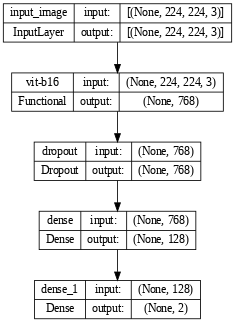

In [ ]:
# Explore model visually
plot_model(
    model_vit_b16, dpi=60,
    show_shapes=True
)

In [ ]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_vit_b16.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_vit_b16.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

vit_b16_history = train_model(
    model_vit_b16, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)